# Advanced Lane Finding Project

The goals / steps of this project are the following:
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

# Camera calibration. Compute the Camera calbration matrix, and Destortion coefficients using the provided chessboard images.

* Import Packages

In [1]:
import os
import cv2
import glob
import pickle
import numpy as np
from math import floor
from math import fabs
from os.path import join
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import HTML
from moviepy.editor import VideoFileClip

%matplotlib inline

print("Modules loaded sucessfully")

Modules loaded sucessfully


# First, let's compute the camera calibration Matrix using chessboard images taken with our sample camera

About to calibrate camera using 20 sample images
Processing image 0
Processing image 1
DONE - Processing camera_cal/calibration10.jpg
Processing image 2
DONE - Processing camera_cal/calibration11.jpg
Processing image 3
DONE - Processing camera_cal/calibration12.jpg
Processing image 4
DONE - Processing camera_cal/calibration13.jpg
Processing image 5
DONE - Processing camera_cal/calibration14.jpg
Processing image 6
DONE - Processing camera_cal/calibration15.jpg
Processing image 7
DONE - Processing camera_cal/calibration16.jpg
Processing image 8
DONE - Processing camera_cal/calibration17.jpg
Processing image 9
DONE - Processing camera_cal/calibration18.jpg
Processing image 10
DONE - Processing camera_cal/calibration19.jpg
Processing image 11
DONE - Processing camera_cal/calibration2.jpg
Processing image 12
DONE - Processing camera_cal/calibration20.jpg
Processing image 13
DONE - Processing camera_cal/calibration3.jpg
Processing image 14
Processing image 15
Processing image 16
DONE - Proce

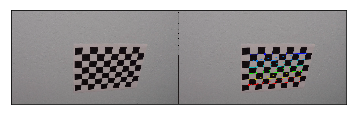

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
nx = 9
ny = 6
objp = np.zeros( (nx * ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# NOTE: the `jupyter notebook` command must be run from the same directory as the `camera_cal` folder. 
# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

print("About to calibrate camera using %s sample images" % len(images))

# dummy vals
img, gray = None, None


# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    print("Processing image %s" % str(idx))
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # for notebook demonstration purposes
    if idx == 1: img_before = np.copy(img)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        write_name = 'camera_cal/corners_marked' + str(idx) + '.jpg'
        cv2.imwrite(write_name, img)
        
        # for notebook demonstration purposes
        if idx == 1: img_after = np.copy(img)
        
        print("DONE - Processing " + fname)


# use our set of image points and object points to approximate camera distortion matrix
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

# save the camera information for future use

# TODO do we need to save this
# cal_cam? bad name.  
cal_cam = {}
cal_cam['ret'] = ret  
cal_cam['mtx'] = mtx     # camera matrix
cal_cam['dist'] = dist   # distortion coefficients
cal_cam['rvecs'] = rvecs 
cal_cam['tvecs'] = tvecs
with open("cal_cam.p", "wb") as file:
    pickle.dump(cal_cam, file)


# remove ticks on the plot
plt.tick_params(axis='x', which='both', top='off', bottom='off', labelbottom='off')         
plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off') 

# show the difference on our sample image
plt.imshow( np.concatenate((img_before, img_after), axis=1) )

print("DONE")

# Load camera calibration matrix and distortion coefficients

In [3]:
# load camera calibration matrix and distortion coefficients
with open("cal_cam.p", "rb") as file:
    cal_cam = pickle.load(file)
    ret = cal_cam['ret']
    mtx = cal_cam['mtx']
    dist = cal_cam['dist']
    rvecs = cal_cam['rvecs'] 
    tvecs = cal_cam['tvecs']
    
print("Calibration matrix:", mtx)
    
print("DONE")

Calibration matrix: [[  1.15396093e+03   0.00000000e+00   6.69705357e+02]
 [  0.00000000e+00   1.14802496e+03   3.85656234e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
DONE


## Use the matrix to correct the distortion

DONE - Camera Distortion Correction


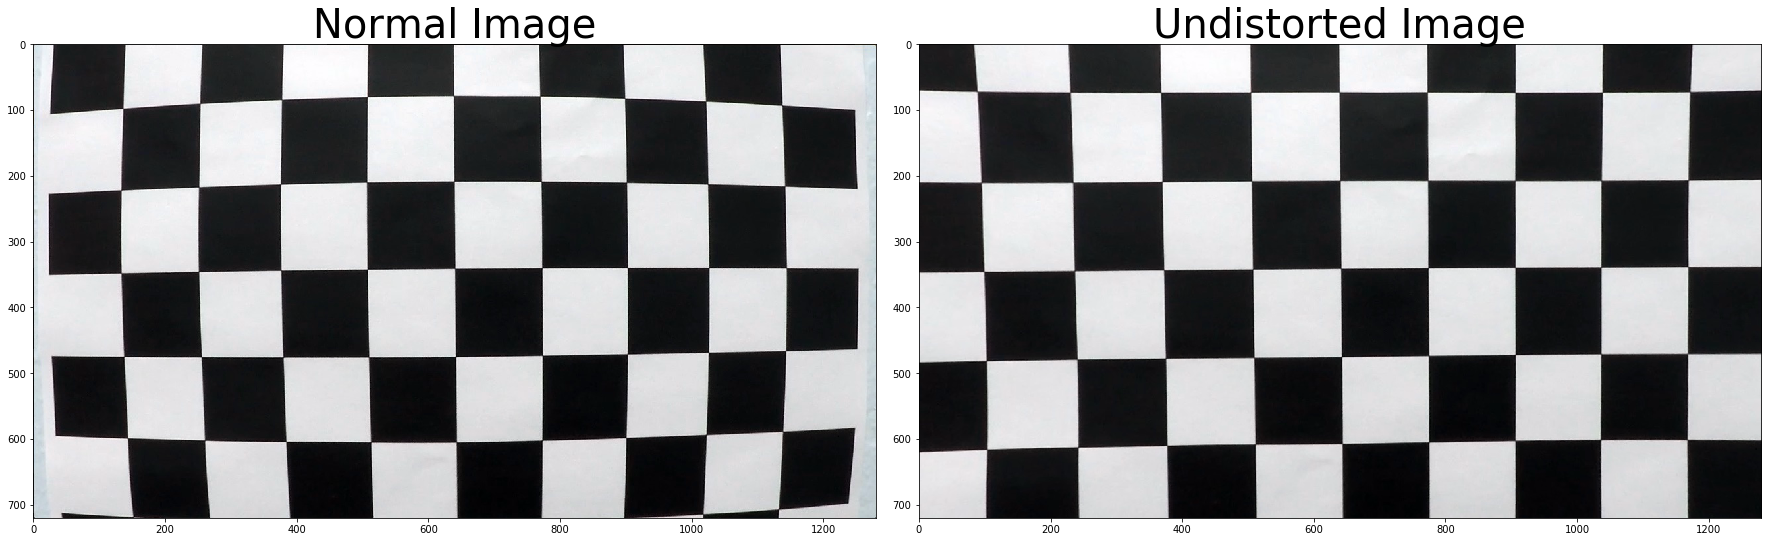

In [4]:
# input a image
# output undistorted image
def distortion_correction(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


# Apply distortion to all images
img = cv2.imread('camera_cal/calibration1.jpg')

img_before = np.copy(img)

# returns our undistorted image
undist = distortion_correction(img, mtx, dist)

# save the image
fname = "camera_cal/undistorted_1.jpg"
cv2.imwrite(fname, undist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.set_title('Normal Image', fontsize=40)
ax1.imshow(img_before)

ax2.set_title('Undistorted Image', fontsize=40)
ax2.imshow(undist)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

print("DONE - Camera Distortion Correction")

## Warping an image to change perspective

DONE


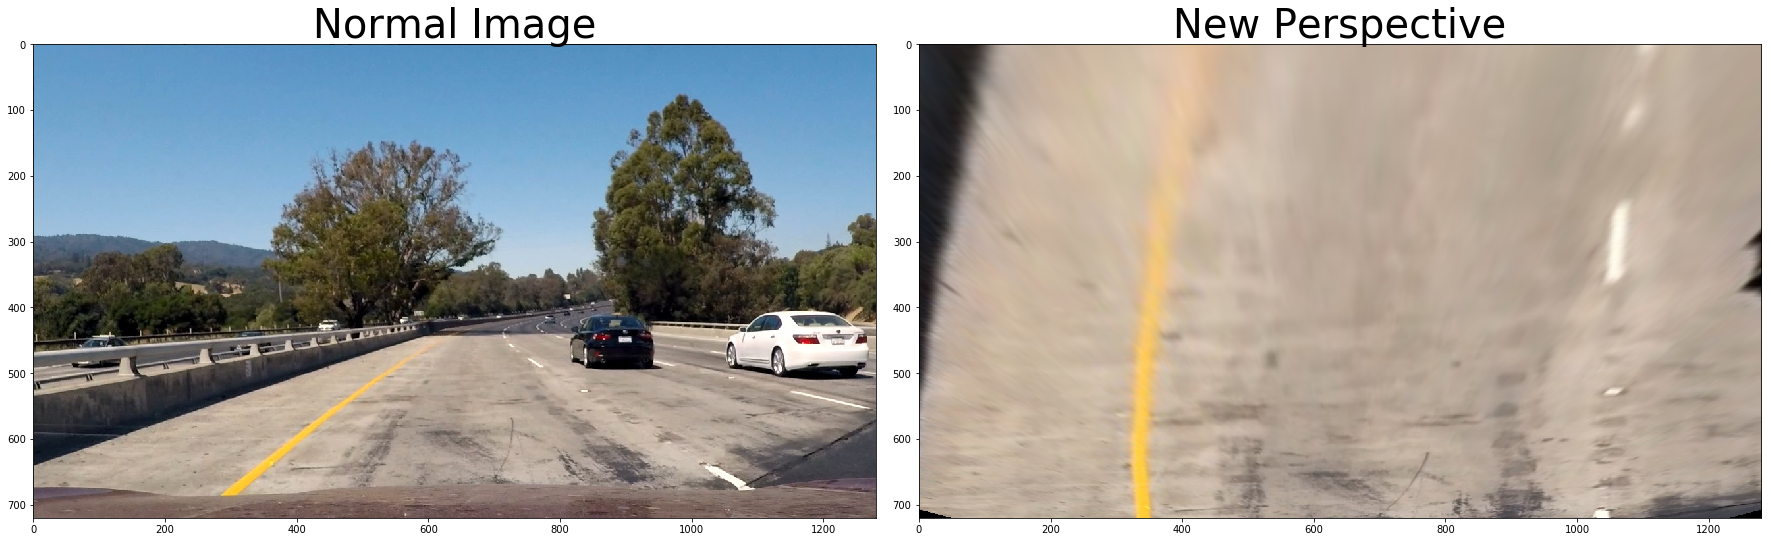

In [5]:
# input a color or gray scale image of the road (1280*720)
# output the bird_view the road, for finding lane line
# if reverse = True, it converts bird view image back to original perspective
def warper(img, reverse = False):
    xsize = img.shape[1]
    ysize = img.shape[0]
    
    # set up box boundary
    xmid = xsize/2 # middle point
    upper_margin = 85  # upper width
    lower_margin = 490 # lower width
    upper_bound  = 460 # upper value of y
    lower_bound  = 670 # bottom value of y
    dst_margin   = 450 # bird view width
    
    # source points
    p1_src = [xmid - lower_margin, lower_bound]
    p2_src = [xmid - upper_margin, upper_bound]
    p3_src = [xmid + upper_margin, upper_bound]
    p4_src = [xmid + lower_margin,lower_bound]
    src = np.array([p1_src, p2_src, p3_src, p4_src], dtype=np.float32)
    
    # distination points
    p1_dst = [xmid - dst_margin, ysize]
    p2_dst = [xmid - dst_margin, 0]
    p3_dst = [xmid + dst_margin, 0]
    p4_dst = [xmid + dst_margin, ysize]
    dst = np.array([p1_dst, p2_dst, p3_dst, p4_dst], dtype=np.float32)
    
    if(not reverse):
        # if we need to change to bird view 
        # given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        # else switch src and dst, change back from bird view
        M = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), cv2.INTER_LINEAR)
    return warped


# demonstrate perspective change
img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


img_before = np.copy(img)

# returns our undistorted image
img = distortion_correction(img, mtx, dist)
# shift perspective on the image
img_after = warper(img)

# save the image
# fname = "camera_cal/birds_eye_1.jpg"
# cv2.imwrite(fname, top_perspective)


# show the difference on our sample image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.set_title('Normal Image', fontsize=40)
ax1.imshow(img_before)

ax2.set_title('New Perspective', fontsize=40)
ax2.imshow(img_after)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


print("DONE")

## Creating thresholded binary image

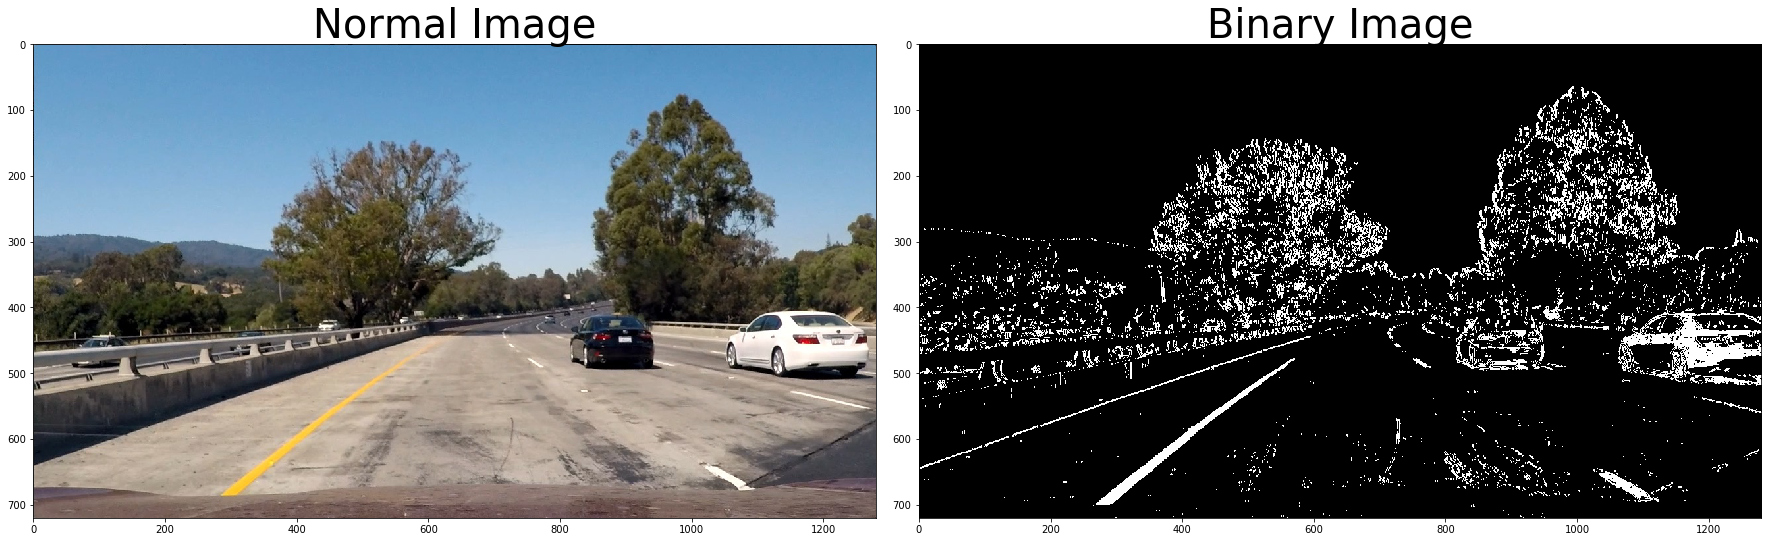

In [6]:
# applying sobel operators and HSV color transforms.
def combined_binary(img):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary


img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_before = np.copy(img)

img = distortion_correction(img, mtx, dist)
img_after = combined_binary(img)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

# left graph
ax1.set_title('Normal Image', fontsize=40)
ax1.imshow(img_before)

# right graph of colored image
ax2.set_title('Binary Image', fontsize=40)
ax2.imshow(img_after, cmap='gray')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Combining binary iamge and prespective shift

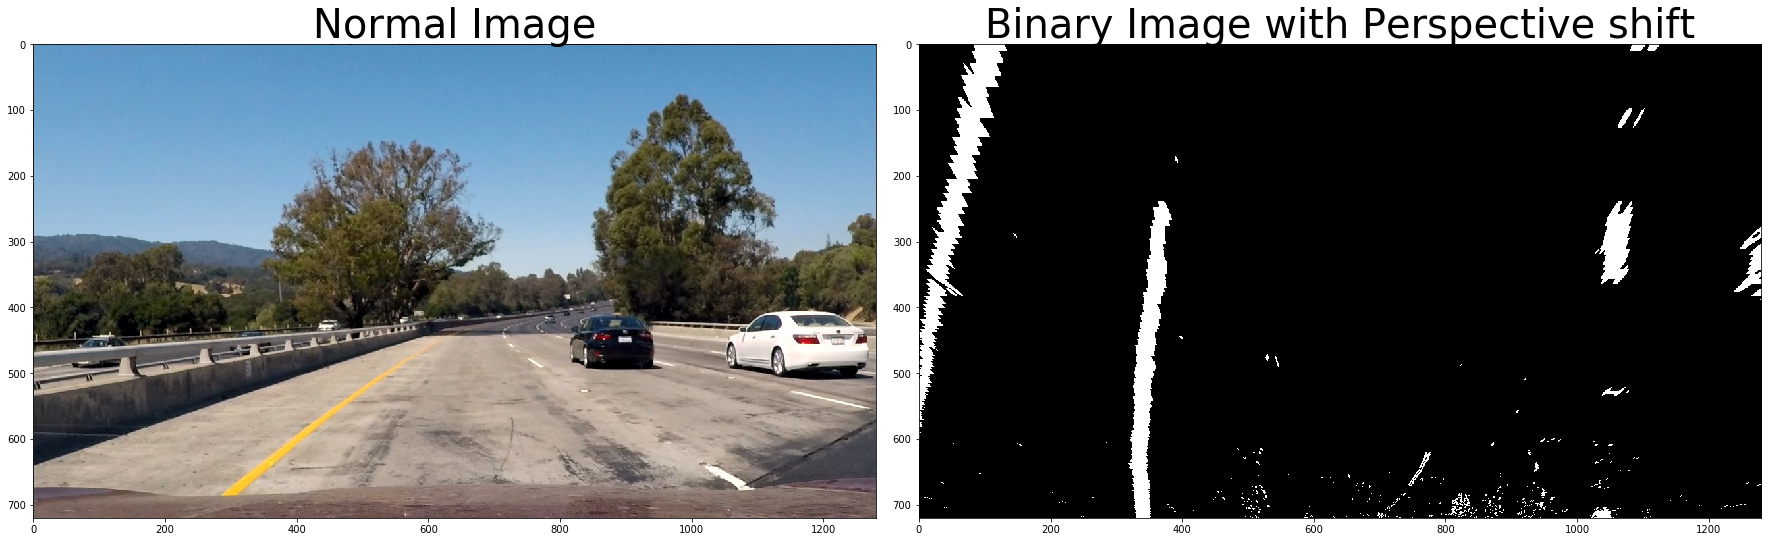

In [7]:
img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_before = np.copy(img)

img = distortion_correction(img, mtx, dist)
img = combined_binary(img)
img_after = warper(img)

## plotting images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

# left graph
ax1.set_title('Normal Image', fontsize=40)
ax1.imshow(img_before)

# right graph of colored image
ax2.set_title('Binary Image with Perspective shift', fontsize=40)
ax2.imshow(img_after, cmap='gray')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Determining the right and left lanes

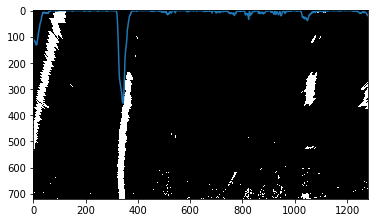

In [8]:
img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img = warper(combined_binary(img))
histogram = np.sum(img[floor(img.shape[0]/2):,:], axis=0)

plt.imshow(img, cmap="gray")
plt.plot(histogram)

## Identifying and Polynomial Curve Fitting of the Lane Lines

(720, 0)

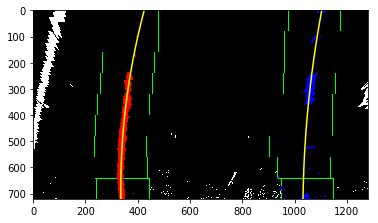

In [9]:
img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


img = combined_binary(img)
binary_warped = warper(img)


# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0) # EDITED
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2) ## EDITED
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)

# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)




## Visualization
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Finding Radius of curvature

image center :  640
lane center :  549.285754267
offset :  90.7142457334578


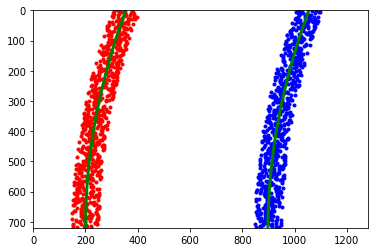

In [10]:
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient

# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# calculate lane separation and separation from center of vehicle
left_lane_lower = left_fit[0]* 719.0**2 + left_fit[1]*719.0 + left_fit[2]
right_lane_lower = right_fit[0]* 719.0**2 + right_fit[1]*719.0 + right_fit[2]

image_center = img.shape[1] // 2
lane_center = ((left_lane_lower + right_lane_lower) / 2 )
offset = fabs(image_center - lane_center)

# print(left_lane_lower, right_lane_lower)

print("image center : ", image_center )
print("lane center : ", lane_center ) 
print("offset : ", offset )

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o',  color='red',  markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

We've plotted our additional sample data based on our polynomials and we can now find our radius of curvature

In [11]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

1665.40071599 1713.97473811


These values however have been calculated in Pixel space, but we can convert it into real world units to make sure our values make sense

In [12]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x, y in world space
left_fit_cr  = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)

# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

# Now our radius of curvature is in meters!
print(left_curverad, 'm', right_curverad, 'm')

547.003871354 m 562.908455834 m


### Calculating our offset from the center of the lane.

If we assume the camera is mounted at the center of the car, such that the center of the car is the midpoint at the bottom of the image, the center of the lane should be between the two lines detected;

We can calculate the distance between the center of the image and the center of the lanes; That way we can always work to keep this offset from the middle of the lane as close to zero as possible.

# Some Polishing

Before we go on to apply all of this unto a video can benefit from cleaning up most of the ideas we've expressed here so far and crating a Line class to store most of our information. That way we can have an easier time with writing our code so that calculating our offsets isn't so painful.

We introduce the Python Line class to simplify this a bit.

In [13]:
# defining our line class
class Line():
    def __init__(self):
        # have we seen this lane before? 
        self.detected = False
        
        # previous n lines
        self.recent_left_fit  = []
        self.recent_right_fit = []
        
        # coefficients of the most recent fit
        self.current_left_fit  = [np.array([False])]
        self.current_right_fit = [np.array([False])]
    
    # get the best coefficients, average the last 3
    def average_fit(self):
        cur_left_fit  = np.average(self.recent_left_fit[-3:], axis=0)
        cur_right_fit = np.average(self.recent_right_fit[-3:], axis=0)
        return cur_left_fit, cur_right_fit
    
    # calculate the offset based on the lines
    # Attempt to confirm that the center of the lanes is in the center of the image. 
    def find_offset(self):
        left_fit, right_fit = self.average_fit()
        base       = 719      # given in lesson
        middle     = 1279/2 # middle of the image
        xm_per_pix = 3.7/650 # meters per pixel in x dimension, given in the lesson
        left_base  = left_fit[0]*base**2 + left_fit[1]*base + left_fit[2]
        right_base = right_fit[0]*base**2 + right_fit[1]*base + right_fit[2]
        offset  = ((right_base - left_base) - middle) * xm_per_pix
        return offset

    # return curvature based on method given in lesson.
    def find_curvature(self):
        left_fit, right_fit = self.average_fit()
        
        # Generate some fake data to represent lane-line pixels
        ploty = np.linspace(0, 719, num=720) # cover same range as the image

        # arbitrary quadratic coefficient
        l_quadratic_coeff = left_fit[0] 
        r_quadratic_coeff = right_fit[0]
        
        # For each y position generate random x position within +/-50 pix
        # of the line base position in each case (x=200 for left, and x=900 for right)
        leftx = np.array([200 + (y**2)*l_quadratic_coeff + np.random.randint(-50, high=51) 
                                      for y in ploty])
        rightx = np.array([900 + (y**2)*r_quadratic_coeff + np.random.randint(-50, high=51) 
                                        for y in ploty])

        leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
        rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

        # Fit a second order polynomial to pixel positions in each fake lane line
        
        # fit to the left line
        left_fit = np.polyfit(ploty, leftx, 2)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        
        # fit to the right line
        right_fit = np.polyfit(ploty, rightx, 2)
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Define y value where we want radius of curvature
        # in this case we'll use the max y value for the bottom of the image.
        y_eval = np.max(ploty)

        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30 /720 # meters per pixel in y dimension
        xm_per_pix = 3.7/650 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        left_fit_cr  = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
        
        # Calculate the new radii of curvature (in meters)
        left_curverad  = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
        return left_curverad, right_curverad


    def find_lane(self, warped):
        if(not self.detected):
            # do our bad search if we've never seen the lines before
            detect = self.blind_search(warped)
        else:
            # do our better search based on what we already know. 
            detect = self.margin_search(warped)
            
        left_fit = self.current_left_fit 
        right_fit = self.current_right_fit
        
        # sanity check pipeline
        # check base distance
        base = 720
        left_base = left_fit[0]*base**2 + left_fit[1]*base + left_fit[2]
        right_base = right_fit[0]*base**2 + right_fit[1]*base + right_fit[2]
        
        if(right_base < left_base or np.absolute((right_base - left_base) - 650) >= 200):
            detect = False
        
        # check derivative difference
        if(np.absolute((2*left_fit[0]+left_fit[1]) - (2*right_fit[0]+right_fit[1])) >= 0.8):
            detect = False
        
        # force to append the first few detection    
        if(len(self.recent_left_fit) < 3 or len(self.recent_right_fit) < 3):
            detect = False
            self.recent_left_fit.append(left_fit)
            self.recent_right_fit.append(right_fit)
        
        # if it is a real dection, we add to recent detection
        if(detect):
            self.detected = True
            self.recent_left_fit.append(left_fit)
            self.recent_right_fit.append(right_fit)
        else:
            self.detected = False

    # use moving histograms to search for new lines
    def blind_search(self, warped):
        # Assuming you have created a warped binary image called "binary_warped"
        binary_warped = np.sum(warped, axis=2) # collapse 3 channel into 1
        binary_y = warped[:,:,0]
        binary_w = warped[:,:,1]
        
        # Take a histogram of the bottom half of the image
        histogram_l = np.sum(binary_y[floor(binary_y.shape[0]/2):,:], axis=0)
        histogram_r = np.sum(binary_w[floor(binary_w.shape[0]/2):,:], axis=0)
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint    = np.int(floor(histogram_l.shape[0]/2))
        leftx_base  = np.argmax(histogram_l[:midpoint])
        rightx_base = np.argmax(histogram_r[midpoint:]) + midpoint
        
        nwindows = 9
        margin = 100
        minpix = 50
        window_height = np.int(binary_warped.shape[0]/nwindows)
        
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero_l = binary_y.nonzero()
        nonzeroy_l = np.array(nonzero_l[0])
        nonzerox_l = np.array(nonzero_l[1])
        
        nonzero_r = binary_w.nonzero()
        nonzeroy_r = np.array(nonzero_r[0])
        nonzerox_r = np.array(nonzero_r[1])
        
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds  = []
        right_lane_inds = []
        leftx           = []
        lefty           = []
        rightx          = []
        righty          = []
        
        # points of current fit
        cur_left_fit, cur_right_fit = self.average_fit()

        # Step through the windows one by one
        for window in range(nwindows):
            # find windows bounds in x and y (and right and left)
            win_y_low       = binary_warped.shape[0] - (window+1)*window_height
            win_y_high      = binary_warped.shape[0] - window*window_height
            win_xleft_low   = leftx_current - margin
            win_xleft_high  = leftx_current + margin
            win_xright_low  = rightx_current - margin
            win_xright_high = rightx_current + margin
            
            # Draw the windows on the visualization image
            cv2.rectangle(warped,(win_xleft_low,win_y_low), (win_xleft_high,win_y_high), (0,255,0), 2) 
            cv2.rectangle(warped,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            
            # Identify the nonzero pixels in x and y within the window
            good_left_inds  = ((nonzeroy_l >= win_y_low) & (nonzeroy_l < win_y_high) & (nonzerox_l >= win_xleft_low)  & (nonzerox_l < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy_r >= win_y_low) & (nonzeroy_r < win_y_high) & (nonzerox_r >= win_xright_low) & (nonzerox_r < win_xright_high)).nonzero()[0]
                        
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            
            # If you found > minpix pixels, recenter next window on their mean position
            if(len(good_left_inds) > minpix):
                leftx_current = np.int(np.mean(nonzerox_l[good_left_inds]))
            if(len(good_right_inds) > minpix):        
                rightx_current = np.int(np.mean(nonzerox_r[good_right_inds]))
        
        # Concatenate the arrays of indices
        left_lane_inds  = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox_l[left_lane_inds]
        lefty = nonzeroy_l[left_lane_inds]

        rightx = nonzerox_r[right_lane_inds]
        righty = nonzeroy_r[right_lane_inds]

        detect = True
        if(len(leftx) > 1000 or len(self.recent_left_fit) < 1):
            self.current_left_fit = np.polyfit(lefty, leftx, 2)
            
        else: # not enough point to suggest a good fit, use last fit
            print("left blind search fail")
            self.current_left_fit = cur_left_fit
            detect = False
            
        if(len(rightx) > 1000 or len(self.recent_right_fit) < 1):
            self.current_right_fit = np.polyfit(righty, rightx, 2)
        else:
            # not enough point to suggest a good fit, use last fit
            print("right blind search fail")
            self.current_right_fit = cur_right_fit
            detect = False
        return detect


    # use best fit coefficients to restrict search area within margin
    def margin_search(self, warped):

        # Assuming you have created a warped binary image called "binary_warped"
        binary_warped = np.sum(warped, axis=2) # collapse 3 channel into 1
        binary_y = warped[:,:,0]
        binary_w = warped[:,:,1]

        nwindows = 9
        margin = 100
        window_height = np.int(binary_warped.shape[0]/nwindows)
        
        # Set minimum number of pixels found to recenter window
        minpix = 50
        maxpix = 6000

        # Identify the x and y positions of all nonzero pixels in the image
        nonzero_l  = binary_y.nonzero()
        nonzeroy_l = np.array(nonzero_l[0])
        nonzerox_l = np.array(nonzero_l[1])
        
        nonzero_r  = binary_w.nonzero()
        nonzeroy_r = np.array(nonzero_r[0])
        nonzerox_r = np.array(nonzero_r[1])
        
        leftx = []
        lefty = []
        rightx = []
        righty =  []
        
        # points of current fit
        cur_left_fit, cur_right_fit = self.average_fit()
        yvals = np.linspace(0, 719, num=720, dtype=np.int32)# to cover same y-range as image
        l_xvals = []
        r_xvals = []
        for y in yvals:
            l_xvals.append(cur_left_fit[0]*y**2 + cur_left_fit[1]*y + cur_left_fit[2] + np.random.randint(-50, high=51))
            r_xvals.append(cur_right_fit[0]*y**2 + cur_right_fit[1]*y + cur_right_fit[2] + np.random.randint(-50, high=51))
        l_xvals = np.array(l_xvals, dtype=np.int32)
        r_xvals = np.array(r_xvals, dtype=np.int32)  
        # Step through the windows one by one
        l_base_missing = 0
        r_base_missing = 0
        
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            
            leftx_current = np.int(cur_left_fit[0]*win_y_high**2 + cur_left_fit[1]*win_y_high + cur_left_fit[2])
            rightx_current = np.int(cur_right_fit[0]*win_y_high**2 + cur_right_fit[1]*win_y_high + cur_right_fit[2])

            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(warped,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 4) 
            cv2.rectangle(warped,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 4) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy_l >= win_y_low) & (nonzeroy_l < win_y_high) & (nonzerox_l >= win_xleft_low) & (nonzerox_l < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy_r >= win_y_low) & (nonzeroy_r < win_y_high) & (nonzerox_r >= win_xright_low) & (nonzerox_r < win_xright_high)).nonzero()[0]
            
            # check left side
            # if the number of points within a reasonable range, it suggest a good detection
            # too less or too much points suggest noise
            if((len(good_left_inds) > minpix) and (len(good_left_inds) < maxpix)):
                leftx.append(nonzerox_l[good_left_inds])
                lefty.append(nonzeroy_l[good_left_inds])
            else:
            # use last fit to generate fake points
            # means when fail to search in this window, 
            # we guess it should have lane line similar to last detection within the same window position
                good_left_inds = ((yvals >= win_y_low) & (yvals < win_y_high) & (l_xvals >= win_xleft_low) & (l_xvals < win_xleft_high)).nonzero()[0]
                if(window <= 4):
                    l_base_missing = l_base_missing + 1
                    leftx.append(l_xvals[good_left_inds])
                    lefty.append(yvals[good_left_inds])
                    # if use fake data, we plot it
                    for p in good_left_inds:
                        cv2.circle(warped, (l_xvals[p], yvals[p]), 3, (0, 255 ,255))
                elif(l_base_missing >= 1):
                    leftx.append(l_xvals[good_left_inds])
                    lefty.append(yvals[good_left_inds])
                    # if use fake data, we plot it
                    for p in good_left_inds:
                        cv2.circle(warped, (l_xvals[p], yvals[p]), 3, (0, 255 ,255))
                        
            # check right side
            # same idea as checking left side
            if((len(good_right_inds) > minpix) and (len(good_right_inds) <= maxpix)):
                rightx.append(nonzerox_r[good_right_inds])
                righty.append(nonzeroy_r[good_right_inds])
            else:
                good_right_inds = ((yvals >= win_y_low) & (yvals < win_y_high) & (r_xvals >= win_xright_low) & (r_xvals < win_xright_high)).nonzero()[0]
                if(window <= 4):
                    r_base_missing = r_base_missing + 1
                    rightx.append(r_xvals[good_right_inds])
                    righty.append(yvals[good_right_inds])
                    for p in good_right_inds:
                        cv2.circle(warped, (r_xvals[p], yvals[p]), 5,(0, 0 ,255))
                elif(r_base_missing >= 1):
                    rightx.append(r_xvals[good_right_inds])
                    righty.append(yvals[good_right_inds])
                    for p in good_right_inds:
                        cv2.circle(warped, (r_xvals[p], yvals[p]), 5,(0, 0 ,255))
        
        leftx = np.concatenate(leftx)
        lefty = np.concatenate(lefty)
        self.current_left_fit = np.polyfit(lefty, leftx, 2)

        rightx = np.concatenate(rightx)
        righty = np.concatenate(righty)
        self.current_right_fit = np.polyfit(righty, rightx, 2)
        
        return True    

print('DONE - Class loading')

DONE - Class loading


### Utility functions dealing with lane lines

In [14]:
def draw_lane(undist, warped, stack, left_fit, right_fit):
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    warped_mask = warped.copy()
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(stack[:,:,0]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    cv2.polylines(stack, np.int_([pts]), True, (255,255,255), 5)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = warper(color_warp, reverse = True)
    
    # Combine the result with the original image
    warped_mask = cv2.addWeighted(warped_mask, 1, color_warp, 0.3, 0)
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result, warped_mask


# find white lane lines
def find_white_lanes(img):
    img = np.copy(img)
    # convert to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # 3 different threshold for different lighting condition
    
    # high light , color = B, used in normal light condition
    lower_1 = np.array([0, 0, 200])
    upper_1 = np.array([255, 25, 255])
    
    # high light , color = G, not used, saved for future experiment
    lower_2 = np.array([0, 0, 200])
    upper_2 = np.array([255, 25, 255])
    
    # low h low s low v , color = R, used in low light condition
    lower_3 = np.array([0, 0, 170])
    upper_3 = np.array([255, 20, 190])

    white_1 = cv2.inRange(hsv, lower_1, upper_1)
    white_2 = cv2.inRange(hsv, lower_2, upper_2)
    white_3 = cv2.inRange(hsv, lower_3, upper_3)

    if(len(white_1.nonzero()[0]) > 4000):
        white_3 = np.zeros_like(white_1)
    
    if(len(white_2.nonzero()[0]) > 40000): # too much false detection
        white_2 = np.zeros_like(white_1)
        
    if(len(white_3.nonzero()[0]) > 40000): # too much false detection
        white_3 = np.zeros_like(white_1)
    
    return white_1, white_2, white_3


# find yellow lane lines
def find_yellow_lanes(img):
    img = np.copy(img)
    # convert to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.float) 
    
    # color = B, high s high v, used in normal light condition
    lower_1 = np.array([ 0, 100, 100])
    upper_1 = np.array([ 50, 255, 255])
    
    # color = G, low s low v, used in low light condition
    lower_2 = np.array([ 10, 35, 100])
    upper_2 = np.array([ 40, 80, 180])
    
    # color = R, low s high v, used in extreme high light condition
    lower_3 = np.array([ 15, 30, 150])
    upper_3 = np.array([ 45, 80, 255])
    
    yellow_1 = cv2.inRange(hsv, lower_1, upper_1)
    yellow_2 = cv2.inRange(hsv, lower_2, upper_2)
    yellow_3 = cv2.inRange(hsv, lower_3, upper_3)

    if(len(yellow_1.nonzero()[0]) > 30000):
        yellow_2 = np.zeros_like(yellow_1)
        yellow_3 = np.zeros_like(yellow_1)
        
    if(len(yellow_2.nonzero()[0]) > 30000):
        yellow_2 = np.zeros_like(yellow_1)
        
    if(len(yellow_3.nonzero()[0]) > 30000):
        yellow_3 = np.zeros_like(yellow_1)

    return yellow_1, yellow_2, yellow_3


## full pipeline function
def final_pipeline(img):
    global tracker
    global frame_id
    frame_id = frame_id + 1
    
    # image is input in RGB format from moviepy
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    # undistort the image
    undist = distortion_correction(img, mtx, dist)
    
    # warp to bird view
    warped  = warper(undist, reverse = False)
    
    # find yellow and white lane line
    # and map to binary image
    yellow_1, yellow_2, yellow_3 = find_yellow_lanes(warped)
    white_1, white_2, white_3    = find_white_lanes(warped)
    
    w = np.zeros_like(white_1)
    w[(white_1 > 0) | (white_2 > 0) | (white_3 > 0)] = 255
    
    y = np.zeros_like(yellow_1)
    y[(yellow_1 > 0) | (yellow_2 > 0 ) | (yellow_3 > 0 )] = 255
    
    # stack yellow and white lane line into one image
    stack = np.zeros_like(img)
    stack[:,:,0] = y
    stack[:,:,1] = w
    
    # find lane lines
    tracker.find_lane(stack)
    
    # get best fitting coefficents
    left_fit, right_fit = tracker.average_fit()
    
    # draw the road mask
    undist = cv2.cvtColor(undist, cv2.COLOR_BGR2RGB)
    result, warped_mask = draw_lane(undist, warped, stack, left_fit, right_fit)
    
    warped = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)
    
    # get statistics
    left_curverad, right_curverad = tracker.find_curvature()
    offset = tracker.find_offset()
    
    # round our numbers for the display purposes 
    left_curverad  = round(left_curverad, 2)
    right_curverad = round(right_curverad, 2)
    offset      = round(float(offset), 2)

    
    # text font and color in video
    text_font   = cv2.FONT_HERSHEY_SIMPLEX
    text_color  = (255, 255, 255) # white for overwriting video
    
    text_panel = np.zeros((240, 640, 3), dtype=np.uint8)
    
    # frame id
    cv2.putText(text_panel, "Frame id:     " + str(frame_id),
                (30, 40), text_font, 1, text_color, 2)
    
    # left curve radius
    cv2.putText(text_panel, 
                "Left Curve Radius: " + str(left_curverad)+"m",
                (30, 80), text_font, 1, text_color, 2)
    
    # right curve radius
    cv2.putText(text_panel, 
                "Right Curve Radius: " + str(right_curverad)+"m",
                (30, 120), text_font, 1, text_color, 2)

    # middle panel radius
    cv2.putText(text_panel, 
                "Center Offset:" + str(offset)+"m", 
                (30, 160), text_font, 1, text_color, 2)
    
    diagScreen = np.zeros((1080, 1920, 3), dtype=np.uint8)

    original_mask = result
    warped        = cv2.resize(warped, (320,240), interpolation=cv2.INTER_AREA)   
    warped_plot   = cv2.resize(stack,  (320,240), interpolation=cv2.INTER_AREA)
    warped_mask   = cv2.resize(warped_mask, (640,480), interpolation=cv2.INTER_AREA)

    # render original video with lane segment drawn in 
    diagScreen[0:720, 0:1280]      = result
    diagScreen[0:480, 1280:1920]   = warped_mask    
    diagScreen[480:720, 1600:1920] = warped_plot
    diagScreen[480:720, 1280:1600] = warped
    diagScreen[720:960, 1280:1920] = text_panel
    
    return diagScreen

print("DONE - Functions loading")

DONE - Functions loading


# Putting the work done together 

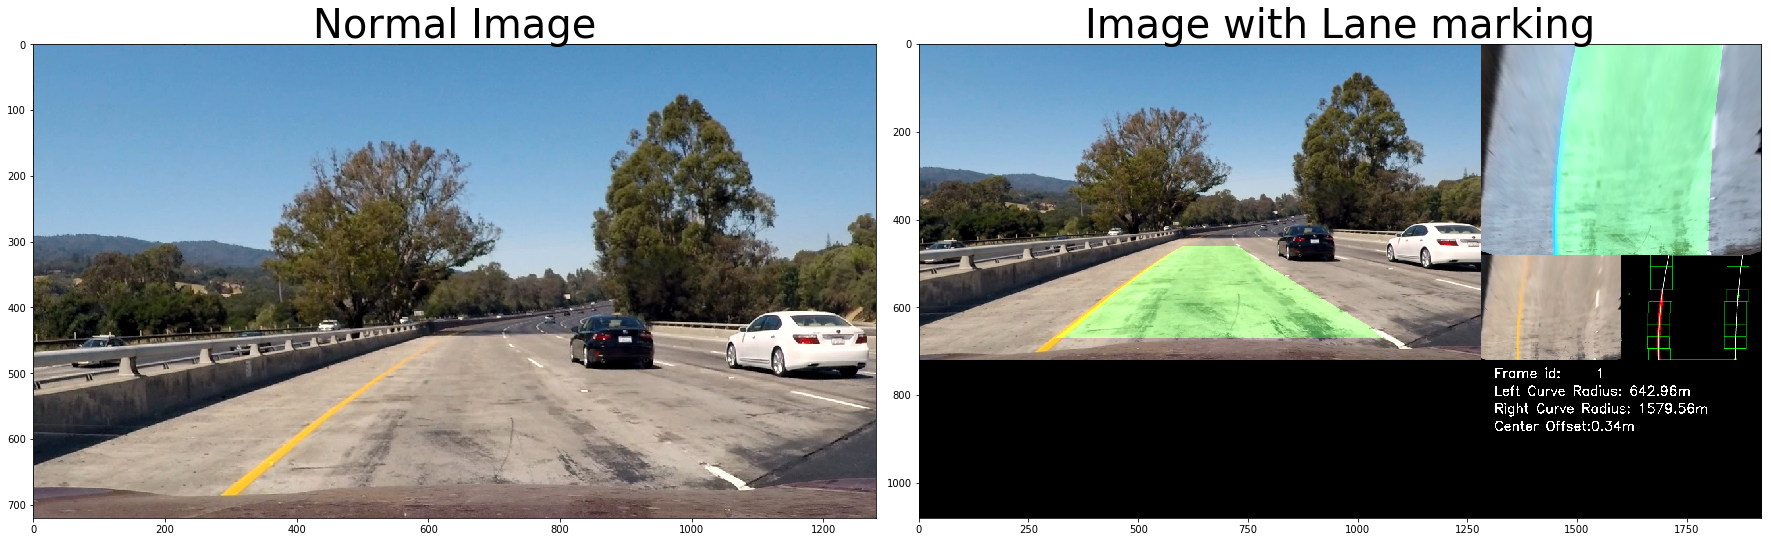

In [15]:
## image display purposes
img = cv2.imread('test_images/test1.jpg')

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_before = np.copy(img)

# initial line object and frame_id
tracker = Line()
frame_id = 0

img_after = final_pipeline(img)

# plotting images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

# left graph
ax1.set_title('Normal Image', fontsize=40)
ax1.imshow(img_before)

# right graph of colored image
ax2.set_title('Image with Lane marking', fontsize=40)
ax2.imshow(img_after)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Apply to all images

In [16]:
# test case
images = glob.glob('test_images/test*.jpg')
for num, fname in enumerate(images):
    tracker = Line()
    img = cv2.imread(fname)
    wname = "output_images/test_image_"+str(num+1)+".jpg"
    # undistortion
    undist = distortion_correction(img, mtx, dist)
    # warp to bird view
    warped  = warper(undist, reverse = False)
    
    # find yellow and white lane line
    # and map to binary image
    yellow_1, yellow_2, yellow_3 = find_yellow_lanes(warped)
    white_1, white_2, white_3    = find_white_lanes(warped)
    w = np.zeros_like(white_1)
    w[(white_1 > 0) | (white_2 > 0) | (white_3 > 0)] = 255
    
    y = np.zeros_like(yellow_1)
    y[(yellow_1 > 0) | (yellow_2 > 0 ) | (yellow_3 > 0 )] = 255
    
    # stack yellow and white lane line into one image
    stack = np.zeros_like(img)
    stack[:,:,0] = y
    stack[:,:,1] = w
    
    # find lane lines
    tracker.find_lane(stack)
    
    # get best fitting coefficents
    left_fit, right_fit = tracker.average_fit()
    
    # draw the road mask
    result, warped = draw_lane(undist, warped, stack, left_fit, right_fit)
    
    # get statistics
    left_curverad, right_curverad = tracker.find_curvature()
    offset = tracker.find_offset()
    
    print("Image #%s - processed" % num)
    cv2.imwrite(wname, result)
    
print("DONE")

Image #0 - processed
Image #1 - processed
Image #2 - processed
Image #3 - processed
Image #4 - processed
Image #5 - processed
DONE


# Apply to videos

In [17]:
# project video

# frame id
frame_id = 0

# read in the project video
input_video_filename = 'project_video.mp4'
output_video_filename = 'project_output.mp4'

clip = VideoFileClip(input_video_filename)
clip = clip.fl_image(final_pipeline)
clip.write_videofile(output_video_filename, audio=False)

%time clip.write_videofile(output_video_filename, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [07:12<00:00,  2.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [08:26<00:00,  2.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 10min 59s, sys: 8.31 s, total: 11min 7s
Wall time: 8min 30s


In [18]:
output_video_filename = 'project_output.mp4'

HTML("""<h1> Project video </h1>
        <br>
        <video width="960" height="540" controls>
          <source src="{0}">
        </video>""".format(output_video_filename))

In [19]:
## Challenge Video

# reset frame id
frame_id = 0

# read in the project video
input_video_filename = 'challenge_video.mp4'
output_video_filename = 'challenge_output.mp4'

clip = VideoFileClip(input_video_filename)
clip = clip.fl_image(final_pipeline)
clip.write_videofile(output_video_filename, audio=False)

%time clip.write_videofile(output_video_filename, audio=False)

[MoviePy] >>>> Building video challenge_output.mp4
[MoviePy] Writing video challenge_output.mp4


100%|██████████| 485/485 [03:07<00:00,  2.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_output.mp4 

[MoviePy] >>>> Building video challenge_output.mp4
[MoviePy] Writing video challenge_output.mp4


100%|██████████| 485/485 [02:42<00:00,  2.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_output.mp4 

CPU times: user 3min 55s, sys: 3.46 s, total: 3min 58s
Wall time: 2min 45s


In [23]:
output_video_filename = 'challenge_output.mp4'
HTML("""<h1> Challenge video </h1>
        <br>
        <video width="960" height="540" controls>
          <source src="{0}">
        </video>""".format(output_video_filename))

In [21]:
## harder challenge video

# reset frame id
frame_id = 0

# read in the project video
input_video_filename = 'harder_challenge_video.mp4'
output_video_filename = 'harder_challenge_output.mp4'

clip = VideoFileClip(input_video_filename)
clip = clip.fl_image(final_pipeline)
clip.write_videofile(output_video_filename, audio=False)

%time clip.write_videofile(output_video_filename, audio=False)

[MoviePy] >>>> Building video harder_challenge_output.mp4
[MoviePy] Writing video harder_challenge_output.mp4


 16%|█▌        | 186/1200 [01:00<05:31,  3.06it/s]

right blind search fail


 16%|█▌        | 187/1200 [01:00<05:18,  3.18it/s]

left blind search fail
right blind search fail


 16%|█▌        | 188/1200 [01:00<05:42,  2.95it/s]

left blind search fail
right blind search fail


 16%|█▌        | 189/1200 [01:01<05:35,  3.01it/s]

left blind search fail


 16%|█▌        | 190/1200 [01:01<05:25,  3.10it/s]

left blind search fail


 16%|█▌        | 191/1200 [01:01<05:16,  3.19it/s]

left blind search fail


 16%|█▌        | 192/1200 [01:02<05:22,  3.12it/s]

left blind search fail


 16%|█▌        | 193/1200 [01:02<05:37,  2.99it/s]

left blind search fail
right blind search fail


 16%|█▌        | 194/1200 [01:02<05:23,  3.11it/s]

right blind search fail


 16%|█▋        | 195/1200 [01:02<05:21,  3.13it/s]

right blind search fail


 16%|█▋        | 197/1200 [01:03<05:25,  3.08it/s]

right blind search fail


 21%|██        | 254/1200 [01:22<05:23,  2.92it/s]

right blind search fail


 21%|██▏       | 255/1200 [01:23<05:15,  3.00it/s]

right blind search fail


 21%|██▏       | 256/1200 [01:23<05:34,  2.82it/s]

right blind search fail


 21%|██▏       | 257/1200 [01:23<05:52,  2.68it/s]

right blind search fail


 22%|██▏       | 258/1200 [01:24<05:59,  2.62it/s]

right blind search fail


 22%|██▏       | 259/1200 [01:24<05:40,  2.76it/s]

right blind search fail


 22%|██▏       | 260/1200 [01:24<05:35,  2.80it/s]

right blind search fail


 22%|██▏       | 261/1200 [01:25<05:33,  2.82it/s]

right blind search fail


 22%|██▏       | 262/1200 [01:25<05:22,  2.91it/s]

right blind search fail


 22%|██▏       | 263/1200 [01:25<05:18,  2.94it/s]

right blind search fail


 22%|██▏       | 264/1200 [01:26<05:21,  2.91it/s]

right blind search fail


 22%|██▏       | 265/1200 [01:26<05:29,  2.84it/s]

right blind search fail


 22%|██▏       | 268/1200 [01:27<05:30,  2.82it/s]

right blind search fail


 22%|██▏       | 269/1200 [01:28<05:33,  2.79it/s]

right blind search fail


 22%|██▎       | 270/1200 [01:28<05:21,  2.89it/s]

right blind search fail


 23%|██▎       | 271/1200 [01:28<05:39,  2.74it/s]

right blind search fail


 23%|██▎       | 272/1200 [01:29<05:43,  2.70it/s]

right blind search fail


 23%|██▎       | 273/1200 [01:29<06:00,  2.57it/s]

right blind search fail


 23%|██▎       | 274/1200 [01:30<06:37,  2.33it/s]

right blind search fail


 23%|██▎       | 275/1200 [01:30<06:48,  2.26it/s]

left blind search fail
right blind search fail


 23%|██▎       | 276/1200 [01:30<06:38,  2.32it/s]

left blind search fail
right blind search fail


 23%|██▎       | 277/1200 [01:31<07:02,  2.19it/s]

left blind search fail
right blind search fail


 23%|██▎       | 278/1200 [01:31<07:05,  2.17it/s]

left blind search fail
right blind search fail


 23%|██▎       | 279/1200 [01:32<07:30,  2.05it/s]

right blind search fail


 23%|██▎       | 280/1200 [01:32<07:22,  2.08it/s]

right blind search fail


 23%|██▎       | 281/1200 [01:33<07:09,  2.14it/s]

right blind search fail


 24%|██▎       | 282/1200 [01:33<06:59,  2.19it/s]

right blind search fail


 24%|██▎       | 284/1200 [01:34<06:03,  2.52it/s]

right blind search fail


 25%|██▍       | 297/1200 [01:40<06:53,  2.19it/s]

right blind search fail


 36%|███▌      | 430/1200 [02:44<05:30,  2.33it/s]

left blind search fail


 36%|███▌      | 431/1200 [02:45<05:14,  2.45it/s]

left blind search fail


 36%|███▌      | 432/1200 [02:45<05:12,  2.46it/s]

left blind search fail


 36%|███▌      | 433/1200 [02:46<05:23,  2.37it/s]

left blind search fail


 36%|███▌      | 434/1200 [02:46<05:17,  2.42it/s]

left blind search fail


 36%|███▋      | 435/1200 [02:46<05:07,  2.49it/s]

left blind search fail


 36%|███▋      | 436/1200 [02:47<05:03,  2.52it/s]

left blind search fail


 36%|███▋      | 437/1200 [02:47<05:04,  2.51it/s]

left blind search fail


 36%|███▋      | 438/1200 [02:48<04:54,  2.59it/s]

left blind search fail


 37%|███▋      | 439/1200 [02:48<04:48,  2.64it/s]

left blind search fail


 37%|███▋      | 440/1200 [02:48<04:47,  2.64it/s]

left blind search fail


 37%|███▋      | 441/1200 [02:49<04:55,  2.57it/s]

left blind search fail


 37%|███▋      | 442/1200 [02:49<04:50,  2.61it/s]

left blind search fail


 37%|███▋      | 443/1200 [02:49<04:39,  2.71it/s]

left blind search fail


 37%|███▋      | 444/1200 [02:50<04:41,  2.69it/s]

left blind search fail


 37%|███▋      | 445/1200 [02:50<04:43,  2.66it/s]

left blind search fail


 37%|███▋      | 446/1200 [02:51<04:40,  2.69it/s]

left blind search fail


 37%|███▋      | 447/1200 [02:51<04:37,  2.71it/s]

left blind search fail


 37%|███▋      | 448/1200 [02:51<04:29,  2.79it/s]

left blind search fail


 37%|███▋      | 449/1200 [02:52<04:23,  2.85it/s]

left blind search fail


 38%|███▊      | 450/1200 [02:52<04:27,  2.81it/s]

left blind search fail


 50%|████▉     | 598/1200 [03:46<03:30,  2.86it/s]

left blind search fail
right blind search fail


 50%|████▉     | 599/1200 [03:47<03:21,  2.98it/s]

left blind search fail
right blind search fail


 50%|█████     | 600/1200 [03:47<03:28,  2.88it/s]

left blind search fail
right blind search fail


 50%|█████     | 601/1200 [03:47<03:26,  2.90it/s]

left blind search fail


 50%|█████     | 602/1200 [03:48<03:20,  2.98it/s]

left blind search fail


 50%|█████     | 603/1200 [03:48<03:15,  3.05it/s]

left blind search fail


 50%|█████     | 604/1200 [03:48<03:21,  2.95it/s]

left blind search fail


 50%|█████     | 605/1200 [03:49<03:27,  2.86it/s]

left blind search fail


 50%|█████     | 606/1200 [03:49<03:21,  2.95it/s]

left blind search fail


 51%|█████     | 607/1200 [03:49<03:19,  2.98it/s]

left blind search fail


 51%|█████     | 608/1200 [03:50<03:24,  2.89it/s]

left blind search fail


 51%|█████     | 609/1200 [03:50<03:23,  2.91it/s]

left blind search fail


 51%|█████     | 610/1200 [03:50<03:19,  2.96it/s]

left blind search fail


 51%|█████     | 611/1200 [03:51<03:21,  2.92it/s]

left blind search fail


 57%|█████▋    | 685/1200 [04:20<03:13,  2.66it/s]

left blind search fail


 57%|█████▋    | 686/1200 [04:20<03:13,  2.66it/s]

left blind search fail


 57%|█████▋    | 687/1200 [04:20<03:11,  2.68it/s]

left blind search fail


 57%|█████▋    | 688/1200 [04:21<03:09,  2.70it/s]

left blind search fail


 57%|█████▋    | 689/1200 [04:21<03:18,  2.57it/s]

left blind search fail


 57%|█████▊    | 690/1200 [04:22<03:14,  2.62it/s]

left blind search fail


 58%|█████▊    | 691/1200 [04:22<03:20,  2.54it/s]

left blind search fail


 58%|█████▊    | 692/1200 [04:22<03:25,  2.48it/s]

left blind search fail


 58%|█████▊    | 693/1200 [04:23<03:36,  2.34it/s]

left blind search fail


 58%|█████▊    | 694/1200 [04:23<03:30,  2.40it/s]

left blind search fail


 58%|█████▊    | 695/1200 [04:24<03:19,  2.53it/s]

left blind search fail


 58%|█████▊    | 696/1200 [04:24<03:09,  2.66it/s]

left blind search fail


 58%|█████▊    | 697/1200 [04:24<03:20,  2.51it/s]

left blind search fail


 58%|█████▊    | 698/1200 [04:25<03:25,  2.44it/s]

left blind search fail


 58%|█████▊    | 699/1200 [04:25<03:26,  2.43it/s]

left blind search fail


 58%|█████▊    | 700/1200 [04:26<03:25,  2.43it/s]

left blind search fail


 58%|█████▊    | 701/1200 [04:26<03:21,  2.47it/s]

left blind search fail


 58%|█████▊    | 702/1200 [04:26<03:17,  2.52it/s]

left blind search fail


 59%|█████▊    | 703/1200 [04:27<03:27,  2.40it/s]

left blind search fail
right blind search fail


 59%|█████▊    | 704/1200 [04:27<03:26,  2.40it/s]

left blind search fail


 59%|█████▉    | 705/1200 [04:28<03:33,  2.32it/s]

left blind search fail


 59%|█████▉    | 706/1200 [04:28<03:42,  2.22it/s]

left blind search fail
right blind search fail


 59%|█████▉    | 707/1200 [04:29<03:33,  2.31it/s]

left blind search fail
right blind search fail


 59%|█████▉    | 708/1200 [04:29<03:20,  2.46it/s]

left blind search fail
right blind search fail


 59%|█████▉    | 709/1200 [04:29<03:21,  2.44it/s]

left blind search fail
right blind search fail


 63%|██████▎   | 754/1200 [04:46<02:37,  2.83it/s]

right blind search fail


 63%|██████▎   | 755/1200 [04:47<02:42,  2.74it/s]

right blind search fail


 63%|██████▎   | 756/1200 [04:47<02:48,  2.63it/s]

right blind search fail


 63%|██████▎   | 757/1200 [04:48<02:46,  2.66it/s]

right blind search fail


 63%|██████▎   | 758/1200 [04:48<02:42,  2.73it/s]

right blind search fail


 63%|██████▎   | 759/1200 [04:48<02:50,  2.58it/s]

right blind search fail


 64%|██████▎   | 762/1200 [04:49<02:34,  2.84it/s]

left blind search fail


 64%|██████▎   | 763/1200 [04:50<02:40,  2.73it/s]

left blind search fail


 64%|██████▎   | 764/1200 [04:50<02:44,  2.64it/s]

left blind search fail
right blind search fail


 64%|██████▍   | 766/1200 [04:51<02:32,  2.84it/s]

right blind search fail


 64%|██████▍   | 767/1200 [04:51<02:41,  2.68it/s]

right blind search fail


 64%|██████▍   | 768/1200 [04:52<02:38,  2.72it/s]

right blind search fail


 64%|██████▍   | 769/1200 [04:52<02:37,  2.74it/s]

right blind search fail


 68%|██████▊   | 818/1200 [05:10<02:30,  2.54it/s]

left blind search fail


 68%|██████▊   | 819/1200 [05:11<02:37,  2.42it/s]

left blind search fail


 68%|██████▊   | 820/1200 [05:11<02:29,  2.54it/s]

left blind search fail


 68%|██████▊   | 821/1200 [05:11<02:24,  2.63it/s]

left blind search fail


 68%|██████▊   | 822/1200 [05:12<02:26,  2.59it/s]

left blind search fail


 69%|██████▊   | 823/1200 [05:12<02:21,  2.66it/s]

left blind search fail


 69%|██████▊   | 824/1200 [05:12<02:18,  2.71it/s]

left blind search fail


 69%|██████▉   | 825/1200 [05:13<02:16,  2.75it/s]

left blind search fail


 69%|██████▉   | 826/1200 [05:13<02:20,  2.66it/s]

left blind search fail


 73%|███████▎  | 872/1200 [05:32<02:33,  2.14it/s]

left blind search fail


 73%|███████▎  | 873/1200 [05:33<02:30,  2.17it/s]

left blind search fail


 73%|███████▎  | 874/1200 [05:33<02:35,  2.10it/s]

left blind search fail


 73%|███████▎  | 875/1200 [05:34<02:33,  2.12it/s]

left blind search fail


 73%|███████▎  | 876/1200 [05:34<02:30,  2.16it/s]

left blind search fail


 73%|███████▎  | 877/1200 [05:34<02:26,  2.21it/s]

left blind search fail


 73%|███████▎  | 878/1200 [05:35<02:27,  2.19it/s]

left blind search fail


 73%|███████▎  | 879/1200 [05:35<02:24,  2.22it/s]

left blind search fail


 73%|███████▎  | 880/1200 [05:36<02:24,  2.22it/s]

left blind search fail


 73%|███████▎  | 881/1200 [05:36<02:21,  2.25it/s]

left blind search fail


 74%|███████▎  | 882/1200 [05:37<02:23,  2.22it/s]

left blind search fail


 74%|███████▎  | 883/1200 [05:37<02:19,  2.27it/s]

left blind search fail


 74%|███████▍  | 885/1200 [05:38<02:17,  2.30it/s]

left blind search fail


 74%|███████▍  | 887/1200 [05:39<02:27,  2.12it/s]

left blind search fail


 74%|███████▍  | 888/1200 [05:40<02:32,  2.04it/s]

left blind search fail


 76%|███████▌  | 910/1200 [05:48<01:38,  2.96it/s]

right blind search fail


 76%|███████▌  | 911/1200 [05:48<01:39,  2.91it/s]

right blind search fail


 76%|███████▌  | 912/1200 [05:48<01:37,  2.95it/s]

right blind search fail


 76%|███████▌  | 913/1200 [05:49<01:35,  2.99it/s]

right blind search fail


 76%|███████▌  | 914/1200 [05:49<01:37,  2.94it/s]

right blind search fail


 76%|███████▋  | 915/1200 [05:49<01:38,  2.90it/s]

right blind search fail


 76%|███████▋  | 916/1200 [05:50<01:39,  2.87it/s]

right blind search fail


 76%|███████▋  | 917/1200 [05:50<01:37,  2.91it/s]

right blind search fail


 76%|███████▋  | 918/1200 [05:50<01:35,  2.95it/s]

left blind search fail
right blind search fail


 77%|███████▋  | 919/1200 [05:51<01:40,  2.78it/s]

left blind search fail
right blind search fail


 77%|███████▋  | 920/1200 [05:51<01:40,  2.77it/s]

left blind search fail
right blind search fail


 77%|███████▋  | 921/1200 [05:52<01:44,  2.68it/s]

left blind search fail
right blind search fail


 77%|███████▋  | 922/1200 [05:52<01:44,  2.65it/s]

left blind search fail
right blind search fail


 77%|███████▋  | 923/1200 [05:52<01:44,  2.65it/s]

left blind search fail
right blind search fail


 77%|███████▋  | 924/1200 [05:53<01:49,  2.52it/s]

left blind search fail
right blind search fail


 77%|███████▋  | 925/1200 [05:53<01:46,  2.59it/s]

left blind search fail
right blind search fail


 77%|███████▋  | 926/1200 [05:54<01:41,  2.69it/s]

left blind search fail
right blind search fail


 77%|███████▋  | 927/1200 [05:54<01:37,  2.81it/s]

right blind search fail


 77%|███████▋  | 928/1200 [05:54<01:41,  2.68it/s]

right blind search fail


 77%|███████▋  | 929/1200 [05:55<01:40,  2.68it/s]

right blind search fail


 78%|███████▊  | 930/1200 [05:55<01:37,  2.77it/s]

right blind search fail


 78%|███████▊  | 931/1200 [05:55<01:41,  2.64it/s]

right blind search fail


 78%|███████▊  | 932/1200 [05:56<01:39,  2.68it/s]

right blind search fail


 78%|███████▊  | 933/1200 [05:56<01:40,  2.66it/s]

right blind search fail


 78%|███████▊  | 934/1200 [05:56<01:35,  2.77it/s]

right blind search fail


 78%|███████▊  | 935/1200 [05:57<01:36,  2.76it/s]

right blind search fail


 78%|███████▊  | 936/1200 [05:57<01:39,  2.66it/s]

right blind search fail


 78%|███████▊  | 937/1200 [05:58<01:37,  2.70it/s]

right blind search fail


 78%|███████▊  | 938/1200 [05:58<01:35,  2.75it/s]

right blind search fail


 78%|███████▊  | 939/1200 [05:58<01:39,  2.61it/s]

right blind search fail


 78%|███████▊  | 940/1200 [05:59<01:39,  2.61it/s]

right blind search fail


 78%|███████▊  | 941/1200 [05:59<01:34,  2.75it/s]

right blind search fail


 78%|███████▊  | 942/1200 [05:59<01:29,  2.87it/s]

right blind search fail


 79%|███████▊  | 943/1200 [06:00<01:29,  2.88it/s]

right blind search fail


 79%|███████▊  | 944/1200 [06:00<01:29,  2.87it/s]

right blind search fail


 79%|███████▉  | 945/1200 [06:00<01:26,  2.93it/s]

right blind search fail


 79%|███████▉  | 946/1200 [06:01<01:25,  2.97it/s]

right blind search fail


 79%|███████▉  | 947/1200 [06:01<01:27,  2.89it/s]

right blind search fail


 79%|███████▉  | 948/1200 [06:01<01:27,  2.87it/s]

right blind search fail


 79%|███████▉  | 949/1200 [06:02<01:24,  2.95it/s]

right blind search fail


 79%|███████▉  | 950/1200 [06:02<01:23,  3.00it/s]

right blind search fail


 79%|███████▉  | 951/1200 [06:02<01:27,  2.85it/s]

right blind search fail


 79%|███████▉  | 952/1200 [06:03<01:29,  2.76it/s]

right blind search fail


 79%|███████▉  | 953/1200 [06:03<01:26,  2.85it/s]

right blind search fail


 80%|███████▉  | 954/1200 [06:04<01:23,  2.94it/s]

right blind search fail


 80%|███████▉  | 955/1200 [06:04<01:25,  2.88it/s]

right blind search fail


 80%|████████  | 960/1200 [06:06<01:20,  2.99it/s]

right blind search fail


 80%|████████  | 961/1200 [06:06<01:19,  2.99it/s]

right blind search fail


 83%|████████▎ | 999/1200 [06:22<01:12,  2.79it/s]

right blind search fail


 83%|████████▎ | 1000/1200 [06:22<01:12,  2.76it/s]

right blind search fail


 83%|████████▎ | 1001/1200 [06:23<01:10,  2.82it/s]

right blind search fail


 84%|████████▎ | 1002/1200 [06:23<01:11,  2.77it/s]

right blind search fail


 84%|████████▎ | 1004/1200 [06:24<01:11,  2.75it/s]

right blind search fail


 84%|████████▍ | 1005/1200 [06:24<01:09,  2.81it/s]

right blind search fail


 84%|████████▍ | 1008/1200 [06:25<01:07,  2.85it/s]

right blind search fail


 84%|████████▍ | 1009/1200 [06:26<01:07,  2.82it/s]

right blind search fail


 84%|████████▍ | 1010/1200 [06:26<01:09,  2.73it/s]

right blind search fail


 84%|████████▍ | 1011/1200 [06:27<01:14,  2.55it/s]

right blind search fail


 84%|████████▍ | 1012/1200 [06:27<01:16,  2.46it/s]

right blind search fail


 85%|████████▌ | 1022/1200 [06:31<01:05,  2.73it/s]

right blind search fail


 87%|████████▋ | 1039/1200 [06:37<01:10,  2.29it/s]

left blind search fail


 87%|████████▋ | 1040/1200 [06:38<01:10,  2.28it/s]

left blind search fail


 87%|████████▋ | 1041/1200 [06:38<01:05,  2.44it/s]

left blind search fail


 87%|████████▋ | 1042/1200 [06:39<01:05,  2.39it/s]

left blind search fail


 87%|████████▋ | 1043/1200 [06:39<01:08,  2.29it/s]

left blind search fail


 87%|████████▋ | 1044/1200 [06:40<01:09,  2.23it/s]

left blind search fail


 87%|████████▋ | 1045/1200 [06:40<01:06,  2.33it/s]

left blind search fail


 87%|████████▋ | 1046/1200 [06:40<01:04,  2.38it/s]

left blind search fail


 87%|████████▋ | 1047/1200 [06:41<01:02,  2.45it/s]

left blind search fail


 87%|████████▋ | 1048/1200 [06:41<01:01,  2.46it/s]

left blind search fail


 87%|████████▋ | 1049/1200 [06:42<00:58,  2.60it/s]

left blind search fail


 88%|████████▊ | 1050/1200 [06:42<00:56,  2.68it/s]

left blind search fail


 88%|████████▊ | 1051/1200 [06:42<00:54,  2.71it/s]

left blind search fail


 88%|████████▊ | 1052/1200 [06:43<00:55,  2.65it/s]

left blind search fail


 88%|████████▊ | 1053/1200 [06:43<00:55,  2.63it/s]

left blind search fail


 88%|████████▊ | 1054/1200 [06:43<00:58,  2.49it/s]

left blind search fail


 88%|████████▊ | 1055/1200 [06:44<01:00,  2.41it/s]

left blind search fail


 88%|████████▊ | 1056/1200 [06:44<01:06,  2.18it/s]

left blind search fail


 88%|████████▊ | 1057/1200 [06:45<01:04,  2.22it/s]

left blind search fail


 88%|████████▊ | 1058/1200 [06:45<01:03,  2.25it/s]

left blind search fail


 88%|████████▊ | 1059/1200 [06:46<00:58,  2.42it/s]

left blind search fail


 89%|████████▉ | 1065/1200 [06:48<00:46,  2.90it/s]

left blind search fail


 89%|████████▉ | 1066/1200 [06:48<00:44,  2.99it/s]

left blind search fail


 89%|████████▉ | 1067/1200 [06:48<00:44,  2.96it/s]

left blind search fail


 89%|████████▉ | 1068/1200 [06:49<00:44,  2.94it/s]

left blind search fail


 89%|████████▉ | 1069/1200 [06:49<00:44,  2.92it/s]

left blind search fail


 89%|████████▉ | 1070/1200 [06:49<00:43,  3.01it/s]

left blind search fail


 89%|████████▉ | 1071/1200 [06:50<00:42,  3.07it/s]

left blind search fail


 89%|████████▉ | 1072/1200 [06:50<00:45,  2.82it/s]

left blind search fail


 89%|████████▉ | 1073/1200 [06:50<00:46,  2.72it/s]

left blind search fail


 90%|████████▉ | 1074/1200 [06:51<00:44,  2.83it/s]

left blind search fail


 90%|████████▉ | 1075/1200 [06:51<00:42,  2.95it/s]

left blind search fail


 90%|████████▉ | 1076/1200 [06:52<00:43,  2.82it/s]

left blind search fail


 93%|█████████▎| 1111/1200 [07:04<00:32,  2.77it/s]

right blind search fail


 93%|█████████▎| 1112/1200 [07:04<00:30,  2.85it/s]

left blind search fail
right blind search fail


 93%|█████████▎| 1113/1200 [07:05<00:29,  2.99it/s]

left blind search fail
right blind search fail


 93%|█████████▎| 1114/1200 [07:05<00:27,  3.08it/s]

left blind search fail
right blind search fail


 93%|█████████▎| 1115/1200 [07:05<00:31,  2.66it/s]

right blind search fail


 93%|█████████▎| 1116/1200 [07:06<00:33,  2.47it/s]

left blind search fail
right blind search fail


 93%|█████████▎| 1117/1200 [07:06<00:32,  2.54it/s]

right blind search fail


 93%|█████████▎| 1118/1200 [07:07<00:35,  2.29it/s]

right blind search fail


 93%|█████████▎| 1119/1200 [07:07<00:39,  2.05it/s]

right blind search fail


 93%|█████████▎| 1120/1200 [07:08<00:39,  2.04it/s]

right blind search fail


 93%|█████████▎| 1121/1200 [07:08<00:37,  2.08it/s]

right blind search fail


 94%|█████████▎| 1122/1200 [07:09<00:38,  2.03it/s]

right blind search fail


 94%|█████████▎| 1123/1200 [07:09<00:39,  1.95it/s]

right blind search fail


 94%|█████████▎| 1124/1200 [07:10<00:39,  1.94it/s]

right blind search fail


 94%|█████████▍| 1125/1200 [07:10<00:36,  2.04it/s]

right blind search fail


 94%|█████████▍| 1126/1200 [07:11<00:38,  1.92it/s]

left blind search fail
right blind search fail


 94%|█████████▍| 1127/1200 [07:11<00:38,  1.88it/s]

right blind search fail


 94%|█████████▍| 1128/1200 [07:12<00:40,  1.80it/s]

right blind search fail


 95%|█████████▍| 1135/1200 [07:16<00:31,  2.06it/s]

right blind search fail


100%|█████████▉| 1199/1200 [07:44<00:00,  2.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_output.mp4 

[MoviePy] >>>> Building video harder_challenge_output.mp4
[MoviePy] Writing video harder_challenge_output.mp4


 16%|█▌        | 186/1200 [01:05<05:27,  3.09it/s]

right blind search fail


 16%|█▌        | 187/1200 [01:05<05:18,  3.18it/s]

left blind search fail
right blind search fail


 16%|█▌        | 188/1200 [01:06<05:37,  3.00it/s]

left blind search fail
right blind search fail


 16%|█▌        | 189/1200 [01:06<05:45,  2.92it/s]

left blind search fail


 16%|█▌        | 190/1200 [01:06<05:29,  3.06it/s]

left blind search fail


 16%|█▌        | 191/1200 [01:06<05:19,  3.16it/s]

left blind search fail


 16%|█▌        | 192/1200 [01:07<05:28,  3.07it/s]

left blind search fail


 16%|█▌        | 193/1200 [01:07<05:30,  3.04it/s]

left blind search fail
right blind search fail


 16%|█▌        | 194/1200 [01:07<05:23,  3.11it/s]

right blind search fail


 16%|█▋        | 195/1200 [01:08<05:15,  3.18it/s]

right blind search fail


 16%|█▋        | 197/1200 [01:08<05:34,  3.00it/s]

right blind search fail


 21%|██        | 254/1200 [01:28<05:37,  2.81it/s]

right blind search fail


 21%|██▏       | 255/1200 [01:28<05:23,  2.92it/s]

right blind search fail


 21%|██▏       | 256/1200 [01:29<05:40,  2.77it/s]

right blind search fail


 21%|██▏       | 257/1200 [01:29<05:49,  2.70it/s]

right blind search fail


 22%|██▏       | 258/1200 [01:30<05:35,  2.81it/s]

right blind search fail


 22%|██▏       | 259/1200 [01:30<05:22,  2.92it/s]

right blind search fail


 22%|██▏       | 260/1200 [01:30<05:28,  2.87it/s]

right blind search fail


 22%|██▏       | 261/1200 [01:31<05:21,  2.92it/s]

right blind search fail


 22%|██▏       | 262/1200 [01:31<05:56,  2.63it/s]

right blind search fail


 22%|██▏       | 263/1200 [01:31<06:02,  2.58it/s]

right blind search fail


 22%|██▏       | 264/1200 [01:32<05:54,  2.64it/s]

right blind search fail


 22%|██▏       | 265/1200 [01:32<05:41,  2.74it/s]

right blind search fail


 22%|██▏       | 268/1200 [01:33<05:41,  2.73it/s]

right blind search fail


 22%|██▏       | 269/1200 [01:34<05:32,  2.80it/s]

right blind search fail


 22%|██▎       | 270/1200 [01:34<05:20,  2.90it/s]

right blind search fail


 23%|██▎       | 271/1200 [01:34<05:09,  3.00it/s]

right blind search fail


 23%|██▎       | 272/1200 [01:35<05:15,  2.94it/s]

right blind search fail


 23%|██▎       | 273/1200 [01:35<05:15,  2.94it/s]

right blind search fail


 23%|██▎       | 274/1200 [01:35<05:09,  3.00it/s]

right blind search fail


 23%|██▎       | 275/1200 [01:35<05:01,  3.07it/s]

left blind search fail
right blind search fail


 23%|██▎       | 276/1200 [01:36<05:13,  2.95it/s]

left blind search fail
right blind search fail


 23%|██▎       | 277/1200 [01:36<05:23,  2.85it/s]

left blind search fail
right blind search fail


 23%|██▎       | 278/1200 [01:37<05:20,  2.87it/s]

left blind search fail
right blind search fail


 23%|██▎       | 279/1200 [01:37<05:22,  2.85it/s]

right blind search fail


 23%|██▎       | 280/1200 [01:37<05:22,  2.85it/s]

right blind search fail


 23%|██▎       | 281/1200 [01:38<05:26,  2.82it/s]

right blind search fail


 24%|██▎       | 282/1200 [01:38<05:18,  2.88it/s]

right blind search fail


 24%|██▎       | 284/1200 [01:39<05:10,  2.95it/s]

right blind search fail


 25%|██▍       | 297/1200 [01:44<05:10,  2.91it/s]

right blind search fail


 36%|███▌      | 430/1200 [02:34<04:34,  2.80it/s]

left blind search fail


 36%|███▌      | 431/1200 [02:34<05:10,  2.48it/s]

left blind search fail


 36%|███▌      | 432/1200 [02:34<05:17,  2.42it/s]

left blind search fail


 36%|███▌      | 433/1200 [02:35<05:05,  2.51it/s]

left blind search fail


 36%|███▌      | 434/1200 [02:35<04:50,  2.63it/s]

left blind search fail


 36%|███▋      | 435/1200 [02:35<04:34,  2.79it/s]

left blind search fail


 36%|███▋      | 436/1200 [02:36<04:43,  2.69it/s]

left blind search fail


 36%|███▋      | 437/1200 [02:36<04:37,  2.75it/s]

left blind search fail


 36%|███▋      | 438/1200 [02:37<04:29,  2.83it/s]

left blind search fail


 37%|███▋      | 439/1200 [02:37<04:28,  2.84it/s]

left blind search fail


 37%|███▋      | 440/1200 [02:37<04:24,  2.88it/s]

left blind search fail


 37%|███▋      | 441/1200 [02:38<04:24,  2.87it/s]

left blind search fail


 37%|███▋      | 442/1200 [02:38<04:31,  2.79it/s]

left blind search fail


 37%|███▋      | 443/1200 [02:38<04:22,  2.88it/s]

left blind search fail


 37%|███▋      | 444/1200 [02:39<04:27,  2.83it/s]

left blind search fail


 37%|███▋      | 445/1200 [02:39<04:25,  2.84it/s]

left blind search fail


 37%|███▋      | 446/1200 [02:39<04:23,  2.86it/s]

left blind search fail


 37%|███▋      | 447/1200 [02:40<04:19,  2.90it/s]

left blind search fail


 37%|███▋      | 448/1200 [02:40<04:10,  3.01it/s]

left blind search fail


 37%|███▋      | 449/1200 [02:40<04:10,  2.99it/s]

left blind search fail


 38%|███▊      | 450/1200 [02:41<04:09,  3.00it/s]

left blind search fail


 50%|████▉     | 597/1200 [03:31<03:23,  2.97it/s]

left blind search fail
right blind search fail


 50%|████▉     | 598/1200 [03:31<03:13,  3.11it/s]

left blind search fail
right blind search fail


 50%|████▉     | 599/1200 [03:31<03:10,  3.16it/s]

left blind search fail
right blind search fail


 50%|█████     | 600/1200 [03:32<03:22,  2.96it/s]

left blind search fail
right blind search fail


 50%|█████     | 601/1200 [03:32<03:28,  2.88it/s]

left blind search fail


 50%|█████     | 602/1200 [03:32<03:17,  3.02it/s]

left blind search fail


 50%|█████     | 603/1200 [03:33<03:16,  3.03it/s]

left blind search fail


 50%|█████     | 604/1200 [03:33<03:21,  2.96it/s]

left blind search fail


 50%|█████     | 605/1200 [03:33<03:16,  3.03it/s]

left blind search fail


 50%|█████     | 606/1200 [03:34<03:12,  3.09it/s]

left blind search fail


 51%|█████     | 607/1200 [03:34<03:10,  3.11it/s]

left blind search fail


 51%|█████     | 608/1200 [03:34<03:14,  3.04it/s]

left blind search fail


 51%|█████     | 609/1200 [03:35<03:21,  2.93it/s]

left blind search fail


 51%|█████     | 610/1200 [03:35<03:16,  3.00it/s]

left blind search fail


 51%|█████     | 611/1200 [03:35<03:13,  3.05it/s]

left blind search fail


 57%|█████▋    | 685/1200 [04:05<03:10,  2.71it/s]

left blind search fail


 57%|█████▋    | 686/1200 [04:05<03:08,  2.73it/s]

left blind search fail


 57%|█████▋    | 687/1200 [04:05<03:01,  2.83it/s]

left blind search fail


 57%|█████▋    | 688/1200 [04:06<02:58,  2.87it/s]

left blind search fail


 57%|█████▋    | 689/1200 [04:06<03:07,  2.72it/s]

left blind search fail


 57%|█████▊    | 690/1200 [04:06<03:03,  2.78it/s]

left blind search fail


 58%|█████▊    | 691/1200 [04:07<02:58,  2.85it/s]

left blind search fail


 58%|█████▊    | 692/1200 [04:07<02:54,  2.91it/s]

left blind search fail


 58%|█████▊    | 693/1200 [04:07<02:54,  2.91it/s]

left blind search fail


 58%|█████▊    | 694/1200 [04:08<02:58,  2.83it/s]

left blind search fail


 58%|█████▊    | 695/1200 [04:08<02:55,  2.88it/s]

left blind search fail


 58%|█████▊    | 696/1200 [04:08<02:53,  2.90it/s]

left blind search fail


 58%|█████▊    | 697/1200 [04:09<02:53,  2.90it/s]

left blind search fail


 58%|█████▊    | 698/1200 [04:09<02:55,  2.85it/s]

left blind search fail


 58%|█████▊    | 699/1200 [04:09<02:48,  2.97it/s]

left blind search fail


 58%|█████▊    | 700/1200 [04:10<02:43,  3.06it/s]

left blind search fail


 58%|█████▊    | 701/1200 [04:10<02:48,  2.96it/s]

left blind search fail


 58%|█████▊    | 702/1200 [04:10<02:51,  2.91it/s]

left blind search fail


 59%|█████▊    | 703/1200 [04:11<02:47,  2.96it/s]

left blind search fail
right blind search fail


 59%|█████▊    | 704/1200 [04:11<02:46,  2.98it/s]

left blind search fail


 59%|█████▉    | 705/1200 [04:11<02:45,  3.00it/s]

left blind search fail


 59%|█████▉    | 706/1200 [04:12<02:48,  2.93it/s]

left blind search fail
right blind search fail


 59%|█████▉    | 707/1200 [04:12<02:53,  2.83it/s]

left blind search fail
right blind search fail


 59%|█████▉    | 708/1200 [04:12<02:45,  2.97it/s]

left blind search fail
right blind search fail


 59%|█████▉    | 709/1200 [04:13<02:48,  2.91it/s]

left blind search fail
right blind search fail


 63%|██████▎   | 754/1200 [04:28<02:30,  2.97it/s]

right blind search fail


 63%|██████▎   | 755/1200 [04:29<02:33,  2.89it/s]

right blind search fail


 63%|██████▎   | 756/1200 [04:29<02:32,  2.91it/s]

right blind search fail


 63%|██████▎   | 757/1200 [04:29<02:28,  2.99it/s]

right blind search fail


 63%|██████▎   | 758/1200 [04:30<02:28,  2.99it/s]

right blind search fail


 63%|██████▎   | 759/1200 [04:30<02:33,  2.88it/s]

right blind search fail


 64%|██████▎   | 762/1200 [04:31<02:22,  3.07it/s]

left blind search fail


 64%|██████▎   | 763/1200 [04:32<02:27,  2.95it/s]

left blind search fail


 64%|██████▎   | 764/1200 [04:32<02:27,  2.95it/s]

left blind search fail
right blind search fail


 64%|██████▍   | 766/1200 [04:32<02:20,  3.09it/s]

right blind search fail


 64%|██████▍   | 767/1200 [04:33<02:24,  3.00it/s]

right blind search fail


 64%|██████▍   | 768/1200 [04:33<02:24,  2.98it/s]

right blind search fail


 64%|██████▍   | 769/1200 [04:34<02:27,  2.93it/s]

right blind search fail


 68%|██████▊   | 818/1200 [04:51<02:22,  2.69it/s]

left blind search fail


 68%|██████▊   | 819/1200 [04:51<02:21,  2.69it/s]

left blind search fail


 68%|██████▊   | 820/1200 [04:52<02:15,  2.79it/s]

left blind search fail


 68%|██████▊   | 821/1200 [04:52<02:19,  2.73it/s]

left blind search fail


 68%|██████▊   | 822/1200 [04:53<02:18,  2.74it/s]

left blind search fail


 69%|██████▊   | 823/1200 [04:53<02:17,  2.75it/s]

left blind search fail


 69%|██████▊   | 824/1200 [04:53<02:14,  2.79it/s]

left blind search fail


 69%|██████▉   | 825/1200 [04:54<02:12,  2.82it/s]

left blind search fail


 69%|██████▉   | 826/1200 [04:54<02:11,  2.83it/s]

left blind search fail


 73%|███████▎  | 872/1200 [05:12<02:20,  2.33it/s]

left blind search fail


 73%|███████▎  | 873/1200 [05:13<02:21,  2.32it/s]

left blind search fail


 73%|███████▎  | 874/1200 [05:13<02:22,  2.29it/s]

left blind search fail


 73%|███████▎  | 875/1200 [05:14<02:21,  2.29it/s]

left blind search fail


 73%|███████▎  | 876/1200 [05:14<02:18,  2.33it/s]

left blind search fail


 73%|███████▎  | 877/1200 [05:14<02:16,  2.37it/s]

left blind search fail


 73%|███████▎  | 878/1200 [05:15<02:18,  2.33it/s]

left blind search fail


 73%|███████▎  | 879/1200 [05:15<02:15,  2.36it/s]

left blind search fail


 73%|███████▎  | 880/1200 [05:16<02:13,  2.39it/s]

left blind search fail


 73%|███████▎  | 881/1200 [05:16<02:12,  2.40it/s]

left blind search fail


 74%|███████▎  | 882/1200 [05:16<02:13,  2.39it/s]

left blind search fail


 74%|███████▎  | 883/1200 [05:17<02:12,  2.40it/s]

left blind search fail


 74%|███████▍  | 885/1200 [05:18<02:06,  2.50it/s]

left blind search fail


 74%|███████▍  | 887/1200 [05:19<02:16,  2.30it/s]

left blind search fail


 74%|███████▍  | 888/1200 [05:19<02:12,  2.36it/s]

left blind search fail


 76%|███████▌  | 910/1200 [05:27<01:34,  3.07it/s]

right blind search fail


 76%|███████▌  | 911/1200 [05:27<01:34,  3.06it/s]

right blind search fail


 76%|███████▌  | 912/1200 [05:27<01:32,  3.12it/s]

right blind search fail


 76%|███████▌  | 913/1200 [05:28<01:31,  3.13it/s]

right blind search fail


 76%|███████▌  | 914/1200 [05:28<01:36,  2.95it/s]

right blind search fail


 76%|███████▋  | 915/1200 [05:28<01:35,  2.99it/s]

right blind search fail


 76%|███████▋  | 916/1200 [05:29<01:35,  2.98it/s]

right blind search fail


 76%|███████▋  | 917/1200 [05:29<01:33,  3.01it/s]

right blind search fail


 76%|███████▋  | 918/1200 [05:29<01:33,  3.02it/s]

left blind search fail
right blind search fail


 77%|███████▋  | 919/1200 [05:30<01:34,  2.97it/s]

left blind search fail
right blind search fail


 77%|███████▋  | 920/1200 [05:30<01:33,  3.00it/s]

left blind search fail
right blind search fail


 77%|███████▋  | 921/1200 [05:30<01:34,  2.96it/s]

left blind search fail
right blind search fail


 77%|███████▋  | 922/1200 [05:31<01:31,  3.04it/s]

left blind search fail
right blind search fail


 77%|███████▋  | 923/1200 [05:31<01:28,  3.13it/s]

left blind search fail
right blind search fail


 77%|███████▋  | 924/1200 [05:31<01:30,  3.05it/s]

left blind search fail
right blind search fail


 77%|███████▋  | 925/1200 [05:32<01:29,  3.06it/s]

left blind search fail
right blind search fail


 77%|███████▋  | 926/1200 [05:32<01:26,  3.17it/s]

left blind search fail
right blind search fail


 77%|███████▋  | 927/1200 [05:32<01:24,  3.24it/s]

right blind search fail


 77%|███████▋  | 928/1200 [05:33<01:27,  3.09it/s]

right blind search fail


 77%|███████▋  | 929/1200 [05:33<01:30,  2.99it/s]

right blind search fail


 78%|███████▊  | 930/1200 [05:33<01:28,  3.06it/s]

right blind search fail


 78%|███████▊  | 931/1200 [05:34<01:27,  3.08it/s]

right blind search fail


 78%|███████▊  | 932/1200 [05:34<01:27,  3.07it/s]

right blind search fail


 78%|███████▊  | 933/1200 [05:34<01:28,  3.03it/s]

right blind search fail


 78%|███████▊  | 934/1200 [05:35<01:25,  3.10it/s]

right blind search fail


 78%|███████▊  | 935/1200 [05:35<01:29,  2.96it/s]

right blind search fail


 78%|███████▊  | 936/1200 [05:35<01:29,  2.96it/s]

right blind search fail


 78%|███████▊  | 937/1200 [05:36<01:26,  3.05it/s]

right blind search fail


 78%|███████▊  | 938/1200 [05:36<01:23,  3.14it/s]

right blind search fail


 78%|███████▊  | 939/1200 [05:36<01:23,  3.13it/s]

right blind search fail


 78%|███████▊  | 940/1200 [05:37<01:24,  3.09it/s]

right blind search fail


 78%|███████▊  | 941/1200 [05:37<01:21,  3.18it/s]

right blind search fail


 78%|███████▊  | 942/1200 [05:37<01:19,  3.25it/s]

right blind search fail


 79%|███████▊  | 943/1200 [05:37<01:24,  3.03it/s]

right blind search fail


 79%|███████▊  | 944/1200 [05:38<01:23,  3.08it/s]

right blind search fail


 79%|███████▉  | 945/1200 [05:38<01:21,  3.13it/s]

right blind search fail


 79%|███████▉  | 946/1200 [05:38<01:21,  3.12it/s]

right blind search fail


 79%|███████▉  | 947/1200 [05:39<01:24,  2.98it/s]

right blind search fail


 79%|███████▉  | 948/1200 [05:39<01:25,  2.95it/s]

right blind search fail


 79%|███████▉  | 949/1200 [05:39<01:24,  2.96it/s]

right blind search fail


 79%|███████▉  | 950/1200 [05:40<01:28,  2.83it/s]

right blind search fail


 79%|███████▉  | 951/1200 [05:40<01:37,  2.55it/s]

right blind search fail


 79%|███████▉  | 952/1200 [05:41<01:36,  2.58it/s]

right blind search fail


 79%|███████▉  | 953/1200 [05:41<01:33,  2.63it/s]

right blind search fail


 80%|███████▉  | 954/1200 [05:41<01:32,  2.65it/s]

right blind search fail


 80%|███████▉  | 955/1200 [05:42<01:33,  2.63it/s]

right blind search fail


 80%|████████  | 960/1200 [05:44<01:30,  2.64it/s]

right blind search fail


 80%|████████  | 961/1200 [05:44<01:24,  2.83it/s]

right blind search fail


 83%|████████▎ | 999/1200 [05:57<01:08,  2.94it/s]

right blind search fail


 83%|████████▎ | 1000/1200 [05:57<01:14,  2.67it/s]

right blind search fail


 83%|████████▎ | 1001/1200 [05:57<01:16,  2.60it/s]

right blind search fail


 84%|████████▎ | 1002/1200 [05:58<01:14,  2.66it/s]

right blind search fail


 84%|████████▎ | 1004/1200 [05:59<01:16,  2.56it/s]

right blind search fail


 84%|████████▍ | 1005/1200 [05:59<01:18,  2.49it/s]

right blind search fail


 84%|████████▍ | 1008/1200 [06:00<01:19,  2.42it/s]

right blind search fail


 84%|████████▍ | 1009/1200 [06:01<01:17,  2.46it/s]

right blind search fail


 84%|████████▍ | 1010/1200 [06:01<01:16,  2.50it/s]

right blind search fail


 84%|████████▍ | 1011/1200 [06:01<01:17,  2.43it/s]

right blind search fail


 84%|████████▍ | 1012/1200 [06:02<01:19,  2.36it/s]

right blind search fail


 85%|████████▌ | 1022/1200 [06:06<01:06,  2.70it/s]

right blind search fail


 87%|████████▋ | 1039/1200 [06:12<00:59,  2.68it/s]

left blind search fail


 87%|████████▋ | 1040/1200 [06:12<01:01,  2.60it/s]

left blind search fail


 87%|████████▋ | 1041/1200 [06:13<01:00,  2.64it/s]

left blind search fail


 87%|████████▋ | 1042/1200 [06:13<00:58,  2.71it/s]

left blind search fail


 87%|████████▋ | 1043/1200 [06:14<00:58,  2.69it/s]

left blind search fail


 87%|████████▋ | 1044/1200 [06:14<00:59,  2.64it/s]

left blind search fail


 87%|████████▋ | 1045/1200 [06:14<00:57,  2.70it/s]

left blind search fail


 87%|████████▋ | 1046/1200 [06:15<00:56,  2.72it/s]

left blind search fail


 87%|████████▋ | 1047/1200 [06:15<00:54,  2.80it/s]

left blind search fail


 87%|████████▋ | 1048/1200 [06:15<00:56,  2.67it/s]

left blind search fail


 87%|████████▋ | 1049/1200 [06:16<00:57,  2.61it/s]

left blind search fail


 88%|████████▊ | 1050/1200 [06:16<00:56,  2.63it/s]

left blind search fail


 88%|████████▊ | 1051/1200 [06:17<00:54,  2.72it/s]

left blind search fail


 88%|████████▊ | 1052/1200 [06:17<00:58,  2.55it/s]

left blind search fail


 88%|████████▊ | 1053/1200 [06:17<00:56,  2.61it/s]

left blind search fail


 88%|████████▊ | 1054/1200 [06:18<00:54,  2.69it/s]

left blind search fail


 88%|████████▊ | 1055/1200 [06:18<00:52,  2.74it/s]

left blind search fail


 88%|████████▊ | 1056/1200 [06:18<00:54,  2.65it/s]

left blind search fail


 88%|████████▊ | 1057/1200 [06:19<00:52,  2.70it/s]

left blind search fail


 88%|████████▊ | 1058/1200 [06:19<00:51,  2.76it/s]

left blind search fail


 88%|████████▊ | 1059/1200 [06:19<00:50,  2.80it/s]

left blind search fail


 89%|████████▉ | 1065/1200 [06:22<00:48,  2.80it/s]

left blind search fail


 89%|████████▉ | 1066/1200 [06:22<00:47,  2.84it/s]

left blind search fail


 89%|████████▉ | 1067/1200 [06:22<00:45,  2.89it/s]

left blind search fail


 89%|████████▉ | 1068/1200 [06:23<00:47,  2.76it/s]

left blind search fail


 89%|████████▉ | 1069/1200 [06:23<00:47,  2.77it/s]

left blind search fail


 89%|████████▉ | 1070/1200 [06:23<00:49,  2.64it/s]

left blind search fail


 89%|████████▉ | 1071/1200 [06:24<00:48,  2.67it/s]

left blind search fail


 89%|████████▉ | 1072/1200 [06:24<00:48,  2.66it/s]

left blind search fail


 89%|████████▉ | 1073/1200 [06:25<00:47,  2.66it/s]

left blind search fail


 90%|████████▉ | 1074/1200 [06:25<00:46,  2.70it/s]

left blind search fail


 90%|████████▉ | 1075/1200 [06:25<00:45,  2.76it/s]

left blind search fail


 90%|████████▉ | 1076/1200 [06:26<00:46,  2.65it/s]

left blind search fail


 93%|█████████▎| 1111/1200 [06:38<00:31,  2.82it/s]

right blind search fail


 93%|█████████▎| 1112/1200 [06:38<00:30,  2.84it/s]

left blind search fail
right blind search fail


 93%|█████████▎| 1113/1200 [06:39<00:30,  2.86it/s]

left blind search fail
right blind search fail


 93%|█████████▎| 1114/1200 [06:39<00:29,  2.87it/s]

left blind search fail
right blind search fail


 93%|█████████▎| 1115/1200 [06:40<00:29,  2.85it/s]

right blind search fail


 93%|█████████▎| 1116/1200 [06:40<00:30,  2.78it/s]

left blind search fail
right blind search fail


 93%|█████████▎| 1117/1200 [06:40<00:28,  2.87it/s]

right blind search fail


 93%|█████████▎| 1118/1200 [06:41<00:29,  2.80it/s]

right blind search fail


 93%|█████████▎| 1119/1200 [06:41<00:28,  2.80it/s]

right blind search fail


 93%|█████████▎| 1120/1200 [06:41<00:28,  2.83it/s]

right blind search fail


 93%|█████████▎| 1121/1200 [06:42<00:27,  2.85it/s]

right blind search fail


 94%|█████████▎| 1122/1200 [06:42<00:27,  2.81it/s]

right blind search fail


 94%|█████████▎| 1123/1200 [06:42<00:28,  2.74it/s]

right blind search fail


 94%|█████████▎| 1124/1200 [06:43<00:28,  2.71it/s]

right blind search fail


 94%|█████████▍| 1125/1200 [06:43<00:27,  2.74it/s]

right blind search fail


 94%|█████████▍| 1126/1200 [06:43<00:27,  2.72it/s]

left blind search fail
right blind search fail


 94%|█████████▍| 1127/1200 [06:44<00:26,  2.73it/s]

right blind search fail


 94%|█████████▍| 1128/1200 [06:44<00:25,  2.79it/s]

right blind search fail


 95%|█████████▍| 1135/1200 [06:47<00:24,  2.68it/s]

right blind search fail


100%|█████████▉| 1199/1200 [07:10<00:00,  2.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_output.mp4 

CPU times: user 10min 4s, sys: 8.37 s, total: 10min 13s
Wall time: 7min 15s


In [22]:
output_video_filename = 'harder_challenge_output.mp4'

HTML("""<h1> Harder challenge video </h1>
        <br>
        <video width="960" height="540" controls>
          <source src="{0}">
        </video>""".format(output_video_filename))